# Recurrent Neural Networks(RNN)


In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed


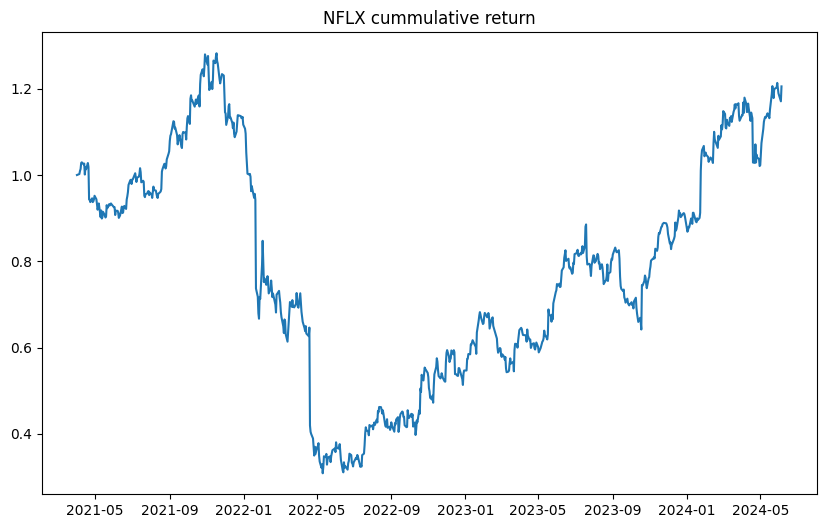

In [145]:
assets = 'NFLX'
period = "800d"
interval="1d"

class Dataset(Dataset):
    def __init__(self, assets, period, interval):
        self.assets = assets
        self.period = period
        self.interval = interval
        self.data = yf.download(self.assets, period=self.period, interval=self.interval)
        self.data['Return'] = self.data['Close'].pct_change().fillna(0)
        self.data['CR'] = (1+self.data['Return']).cumprod()
        
nflx = Dataset(assets, period, interval)

plt.figure(figsize=(10, 6))
plt.plot(nflx.data['CR'])
plt.title('NFLX cummulative return')
plt.show()

[1.         1.0023173  1.00947322 1.01403361 1.02810432 1.02945759
 1.02476743 1.02652849 1.00111237 1.01816764 1.01319935 1.02784476
 1.01881655 0.94342073 0.94319828 0.93721034 0.9460161  0.93721034
 0.93900857 0.94360613 0.95189275 0.94381002 0.93281675 0.91965445
 0.92608729 0.93404029 0.90224689 0.9178006  0.89907684 0.90219128
 0.91463055 0.90641804 0.90148681 0.90411929 0.93001748 0.92300996
 0.93229767 0.92940568 0.93129658 0.93407734 0.93213083 0.92521598
 0.9255126  0.9073264  0.9171703  0.91702202 0.91281382 0.9006155
 0.90332209 0.90610286 0.92671764 0.9119054  0.91285088 0.92384415
 0.92834898 0.92136001 0.94327245 0.95053948 0.96040194 0.97710508
 0.98815403 0.98902528 0.97921849 0.98909939 0.98991509 1.00411559
 0.99358578 0.98394577 0.99362278 0.99608842 1.00233586 1.01581334
 1.00654412 0.98311152 0.98676365 0.98448334 0.95218943 0.94874125
 0.95548921 0.95749139 0.96197766 0.96270069 0.9533388  0.95949357
 0.95500731 0.94698013 0.95908567 0.97306372 0.96501799 0.96394

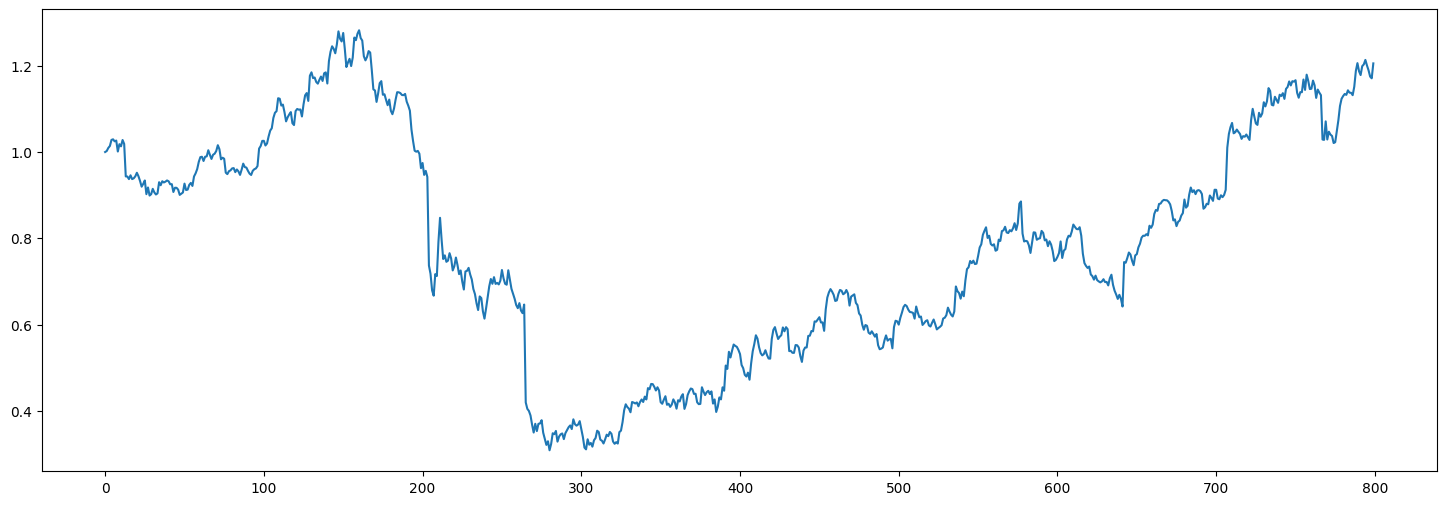

In [129]:
print(nflx.data['CR'].values)
data_ = nflx.data['CR'].values
print(len(data_))
import matplotlib.pylab as plt
plt.figure(figsize=(18,6))
plt.plot(range(len(data_)),data_)
plt.show()

In [130]:
# training_data = [torch.Tensor([data_[i:i+window_size] for i in range(training_size)]).unsqueeze(2) , torch.Tensor([data_[i+window_size] for i in range(training_size)])]
# print(training_data[0].size(),training_data[1].size())
# testing_data = [torch.Tensor([data_[i:i+window_size] for i in range(training_size,training_size+testing_size)]).unsqueeze(2) , torch.Tensor([data_[i+window_size] for i in range(training_size,training_size+testing_size)])]
# print(testing_data[0].size(),testing_data[1].size())


def Dataloader_X(datas,T,batch_size,train_days):
    days = datas.shape[0]
    test_days = days - train_days - T

    N_T_data_train = np.array([datas[i:i+T] for i in range(train_days)])
    N_T_data_test = np.array([datas[i:i+T] for i in range(train_days,days-T)])
    A = [torch.tensor(N_T_data_train[i*batch_size:],dtype = torch.float).unsqueeze(2) if i == train_days//batch_size else torch.tensor(N_T_data_train[i*batch_size:(i+1)*batch_size],dtype = torch.float).unsqueeze(2) for i in range(train_days//batch_size+1)]
    print(A[0].size())
    print(A[-1].size())
    B = [torch.tensor(N_T_data_test[i*batch_size:],dtype = torch.float).unsqueeze(2) if i == test_days//batch_size else torch.tensor(N_T_data_test[i*batch_size:(i+1)*batch_size],dtype = torch.float).unsqueeze(2) for i in range(test_days//batch_size+1)]
    print(B[0].size())
    print(B[-1].size())
    return A,B

def Dataloader_Y(datas,T,batch_size,train_days):
    days = datas.shape[0]
    test_days = days - train_days - T
    datas = datas[T:]
    N_T_data_train = np.array([datas[i:i+1] for i in range(train_days)])
    N_T_data_test = np.array([datas[i:i+1] for i in range(train_days,days-T)])
    A = [torch.tensor(N_T_data_train[i*batch_size:],dtype = torch.float) if i == train_days//batch_size else torch.tensor(N_T_data_train[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(train_days//batch_size+1)]
    print(A[0].size())
    print(A[-1].size())
    B = [torch.tensor(N_T_data_test[i*batch_size:],dtype = torch.float) if i == test_days//batch_size else torch.tensor(N_T_data_test[i*batch_size:(i+1)*batch_size],dtype = torch.float) for i in range(test_days//batch_size+1)]
    print(B[0].size())
    print(B[-1].size())
    return A,B


days = data_.shape[0]
train_days = int(0.7*data_.shape[0])
window_size = 30
test_day = days - train_days - window_size
batch_size = 128
X_train, X_test = Dataloader_X(data_,window_size,batch_size,train_days)
Y_train, Y_test = Dataloader_Y(data_,window_size,batch_size,train_days)

torch.Size([128, 30, 1])
torch.Size([48, 30, 1])
torch.Size([128, 30, 1])
torch.Size([82, 30, 1])
torch.Size([128, 1])
torch.Size([48, 1])
torch.Size([128, 1])
torch.Size([82, 1])


In [131]:
class DRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size,batch_size=batch_size,window_size=window_size, lr=0.00005):
        super(DRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.window_size = window_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.lr = lr
        
    def forward(self, x):
        # Initialize hidden and cell states
        if len(x.size()) == 3:
            h0 = torch.zeros( self.num_layers,x.size()[0] , self.hidden_size)
        else:
            h0 = torch.zeros( self.num_layers , self.hidden_size)
        # Forward propagate RNN
        out, _ = self.rnn(x, h0.detach())
        # Decode the hidden state 
        if len(x.size()) == 3:
            out = self.fc1(out[:,-1])
        else:
            out = self.fc1(out[-1])
        return out

# Model initialization
input_size = 1
hidden_size = 25 # Number of features in hidden state
num_layers = 3 # Number of stacked RNN layers
output_size = 1 # Number of output predictions
model_DRNN = DRNN(input_size, hidden_size, num_layers, output_size)

print(model_DRNN(torch.zeros((64,30,1))).size())

torch.Size([64, 1])


In [132]:
def train_model(model, train_data, test_data, criterion, optimizer, num_epochs=1000):
    hist_loss = []
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(train_data)
        loss = criterion(outputs, test_data)
        # Backward and optimize
        optimizer.zero_grad()
        hist_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        if (epoch+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    plt.plot(hist_loss)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.show()

In [133]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,batch_size=batch_size,window_size=window_size, lr=0.0001):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.window_size = window_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,batch_first=True)
        # Define the output layer
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        self.lr = lr
        
    def forward(self, x):
        # Initialize hidden state and cell state
        if len(x.size()) == 3:
            h0 = torch.zeros(self.num_layers,x.size()[0], self.hidden_dim)
            c0 = torch.zeros(self.num_layers,x.size()[0], self.hidden_dim)
        else:
            h0 = torch.zeros(self.num_layers, self.hidden_dim)
            c0 = torch.zeros(self.num_layers, self.hidden_dim)
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Select the last time step's output for prediction
        if len(x.size()) == 3:
            out = self.linear1(out[:,-1])
        else:
            out = self.linear1(out[-1])
        return out

# Model parameters
input_dim = 1  # number of features
hidden_dim = 25  # can be adjusted
num_layers = 3  # number of LSTM layers
output_dim = 1  # for regression; for classification, this might be the number of classes

# Initialize the model, loss function, and optimizer
model_LSTM = LSTM(input_dim, hidden_dim, num_layers, output_dim)
print(model_LSTM(torch.zeros((64,30,1))).size())

torch.Size([64, 1])


In [134]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,batch_size=batch_size,window_size=window_size, lr=0.0001):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.window_size = window_size
        self.num_layers = num_layers
        # GRU Layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.lr = lr
        
    def forward(self, x):
        # Initialize hidden state with zeros
        if len(x.size()) == 3:
            h0 = torch.zeros(self.num_layers,x.size()[0], self.hidden_dim)
        else:
            h0 = torch.zeros(self.num_layers, self.hidden_dim)
        # Forward propagate GRU
        out, _ = self.gru(x, h0.detach())
        # Decode the hidden state of the last time step
        if len(x.size()) == 3:
            out = self.fc1(out[:,-1])
        else:
            out = self.fc1(out[-1])
        return out

# Hyperparameters
input_dim = 1  
hidden_dim = 25  # Number of hidden layers.
num_layers = 3  # Number of GRU layers. This can be adjusted according to the complexity of the task.
output_dim = 1
# Create the model
model_GRU = GRU(input_dim, hidden_dim, output_dim, num_layers)
print(model_GRU(torch.zeros((64,30,1))).size())

torch.Size([64, 1])


Traning Model: DRNN
Epoch [500/5000], Train Loss: 0.00276692, Test Loss: 0.00308399
Epoch [1000/5000], Train Loss: 0.00156191, Test Loss: 0.00136096
Epoch [1500/5000], Train Loss: 0.00116587, Test Loss: 0.00098301
Epoch [2000/5000], Train Loss: 0.00093250, Test Loss: 0.00076772
Epoch [2500/5000], Train Loss: 0.00074309, Test Loss: 0.00061288
Epoch [3000/5000], Train Loss: 0.00060626, Test Loss: 0.00051424
Epoch [3500/5000], Train Loss: 0.00052874, Test Loss: 0.00045853
Epoch [4000/5000], Train Loss: 0.00048074, Test Loss: 0.00042106
Epoch [4500/5000], Train Loss: 0.00045862, Test Loss: 0.00040259
Epoch [5000/5000], Train Loss: 0.00045093, Test Loss: 0.00039587


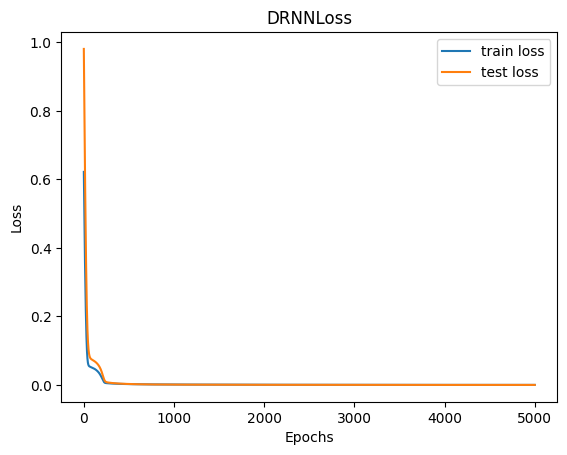

Traning Model: LSTM
Epoch [500/5000], Train Loss: 0.00499625, Test Loss: 0.00328889
Epoch [1000/5000], Train Loss: 0.00241228, Test Loss: 0.00238385
Epoch [1500/5000], Train Loss: 0.00176147, Test Loss: 0.00192160
Epoch [2000/5000], Train Loss: 0.00149930, Test Loss: 0.00146776
Epoch [2500/5000], Train Loss: 0.00120281, Test Loss: 0.00107446
Epoch [3000/5000], Train Loss: 0.00091105, Test Loss: 0.00078488
Epoch [3500/5000], Train Loss: 0.00069309, Test Loss: 0.00058762
Epoch [4000/5000], Train Loss: 0.00055483, Test Loss: 0.00052029
Epoch [4500/5000], Train Loss: 0.00048591, Test Loss: 0.00046742
Epoch [5000/5000], Train Loss: 0.00044448, Test Loss: 0.00043880


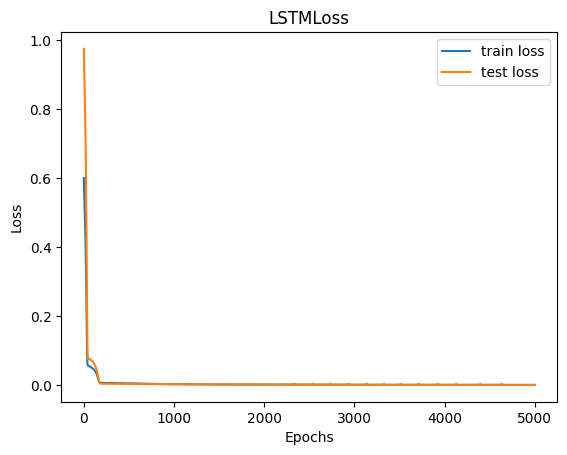

Traning Model: GRU
Epoch [500/5000], Train Loss: 0.00131124, Test Loss: 0.00114364
Epoch [1000/5000], Train Loss: 0.00088335, Test Loss: 0.00074250
Epoch [1500/5000], Train Loss: 0.00066698, Test Loss: 0.00056189
Epoch [2000/5000], Train Loss: 0.00053948, Test Loss: 0.00046694
Epoch [2500/5000], Train Loss: 0.00046693, Test Loss: 0.00041148
Epoch [3000/5000], Train Loss: 0.00045271, Test Loss: 0.00040124
Epoch [3500/5000], Train Loss: 0.00044921, Test Loss: 0.00040107
Epoch [4000/5000], Train Loss: 0.00044543, Test Loss: 0.00040199
Epoch [4500/5000], Train Loss: 0.00044233, Test Loss: 0.00040468
Epoch [5000/5000], Train Loss: 0.00044024, Test Loss: 0.00040834


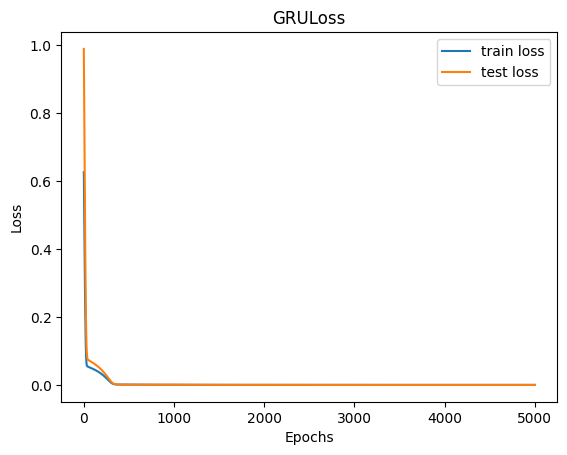

In [135]:
models = {'DRNN': model_DRNN, 'LSTM': model_LSTM, 'GRU': model_GRU,}  # Model dictionary
criterion = nn.MSELoss()  
epochs = 5000

for model_name, model in models.items():  # Iterate over variants
    patience = 20
    best_loss = float('inf')
    epochs_no_improve = 0
    criterion = nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters(), model.lr)
    print(f'Traning Model: {model_name}')
    losses_train = []
    losses_test = []
    for epoch in range(epochs):
        sum = 0
        for x,y in zip(X_train,Y_train):
            pred = model(x)
            loss_train = criterion(pred,y)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            sum+=loss_train.item()
        losses_train.append(sum/len(X_train))
        sum = 0
        for x,y in zip(X_test,Y_test):
            pred = model(x)
            loss_test = criterion(pred,y)
            sum+=loss_test.item()
        losses_test.append(sum/len(X_test))
        if (epoch+1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {losses_train[-1]:.8f}, Test Loss: {losses_test[-1]:.8f}')
        
        # if losses_test[-1] < best_loss:
        #     best_loss = losses_test[-1]
        #     epochs_no_improve = 0
        # elif epoch>200:
        #     epochs_no_improve += 1
        
        # if epochs_no_improve >= patience:
        #     print(f'Early stopping triggered after epoch {epoch+1}.')
        #     break

    plt.plot(losses_train,label = 'train loss')
    plt.plot(losses_test,label = 'test loss')
    plt.title(model_name+'Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.legend()
    plt.show()


[tensor([0.9041]), tensor([0.9146]), tensor([0.9070]), tensor([0.9007]), tensor([0.9049]), tensor([0.9308]), tensor([0.9226]), tensor([0.9341]), tensor([0.9283]), tensor([0.9323]), tensor([0.9341]), tensor([0.9336]), tensor([0.9251]), tensor([0.9268]), tensor([0.9063]), tensor([0.9194]), tensor([0.9165]), tensor([0.9140]), tensor([0.8996]), tensor([0.9044]), tensor([0.9054]), tensor([0.9291]), tensor([0.9103]), tensor([0.9145]), tensor([0.9231]), tensor([0.9294]), tensor([0.9211]), tensor([0.9460]), tensor([0.9495]), tensor([0.9621]), tensor([0.9772]), tensor([0.9887]), tensor([0.9884]), tensor([0.9798]), tensor([0.9901]), tensor([0.9903]), tensor([1.0059]), tensor([0.9931]), tensor([0.9849]), tensor([0.9938]), tensor([0.9965]), tensor([1.0029]), tensor([1.0165]), tensor([1.0053]), tensor([0.9827]), tensor([0.9878]), tensor([0.9844]), tensor([0.9522]), tensor([0.9506]), tensor([0.9555]), tensor([0.9578]), tensor([0.9624]), tensor([0.9625]), tensor([0.9520]), tensor([0.9600]), tensor([0

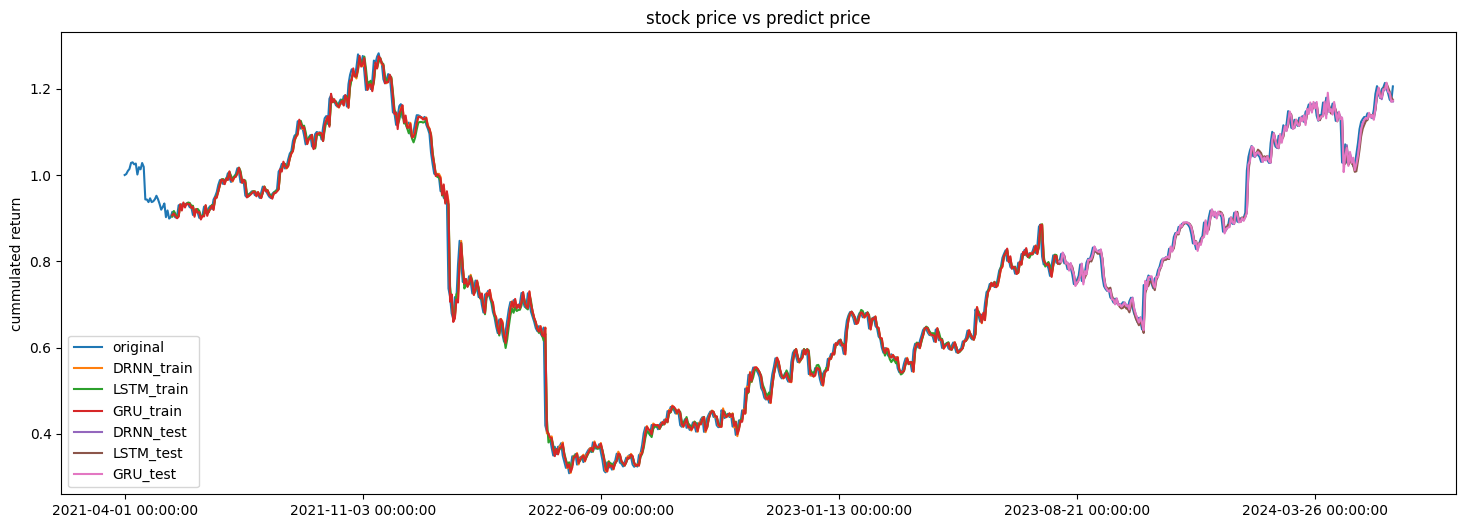

In [144]:
pred_DRNN = []
pred_LSTM = []
pred_GRU = []
X = X_train
for batch  in X:
    for x in batch:
        pred = model_DRNN(x).detach().float()
        pred_DRNN.append(pred)
        pred = model_LSTM(x).detach().float()
        pred_LSTM.append(pred)
        pred = model_GRU(x).detach().float()
        pred_GRU.append(pred)
X= X_test
for batch in X:
    for x in batch:
        pred = model_DRNN(x).detach().float()
        pred_DRNN.append(pred)
        pred = model_LSTM(x).detach().float()
        pred_LSTM.append(pred)
        pred = model_GRU(x).detach().float()
        pred_GRU.append(pred)
print(pred_DRNN)
import matplotlib.pylab as plt
plt.figure(figsize=(18,6))
plt.plot(range(len(data_)),data_,label = 'original')
plt.plot(range(window_size,window_size+len(pred_DRNN[:train_days])),pred_DRNN[:train_days],label = 'DRNN_train')
plt.plot(range(window_size,window_size+len(pred_LSTM[:train_days])),pred_LSTM[:train_days],label = 'LSTM_train')
plt.plot(range(window_size,window_size+len(pred_GRU[:train_days])),pred_GRU[:train_days],label = 'GRU_train')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_DRNN[train_days-1:])),pred_DRNN[train_days-1:],label = 'DRNN_test')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_LSTM[train_days-1:])),pred_LSTM[train_days-1:],label = 'LSTM_test')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_GRU[train_days-1:])),pred_GRU[train_days-1:],label = 'GRU_test')
lables = nflx.data.index
step = 150
ticks = range(0,days,step)
plt.xticks(ticks,lables[ticks])
plt.ylabel('cummulated return')
plt.title('stock price vs predict price')
plt.legend()
plt.show()


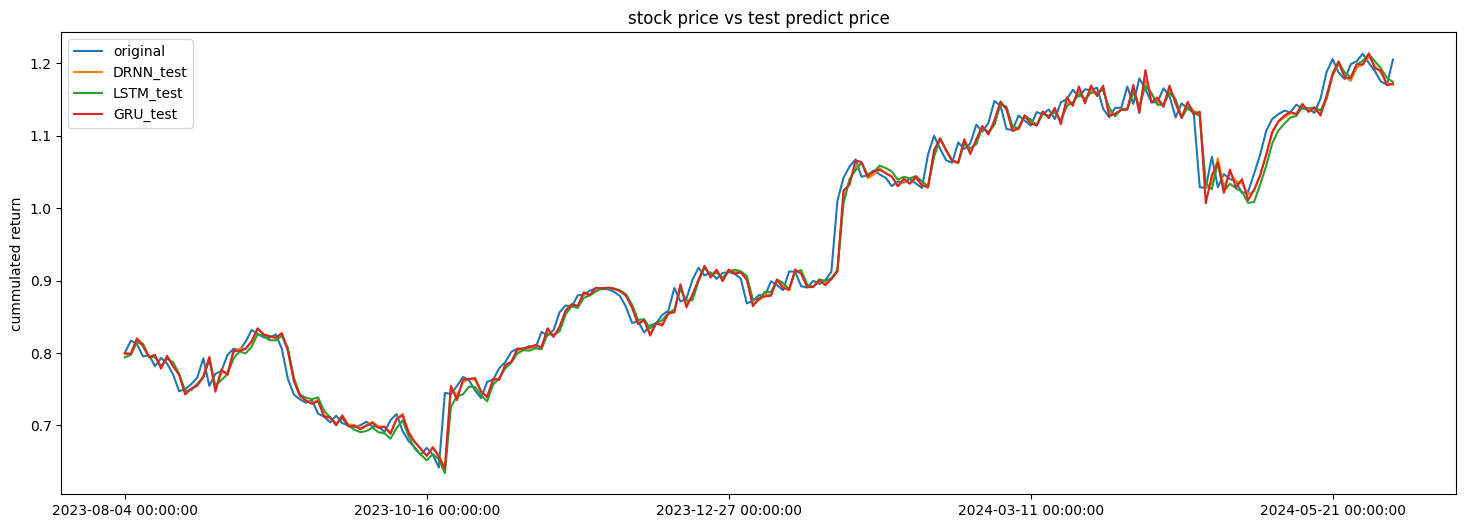

800 770


In [146]:
plt.figure(figsize=(18,6))

plt.plot(range(len(data_[train_days-1+window_size:])),data_[train_days-1+window_size:],label = 'original')
plt.plot(range(len(pred_DRNN[train_days-1:])),pred_DRNN[train_days-1:],label = 'DRNN_test')
plt.plot(range(len(pred_LSTM[train_days-1:])),pred_LSTM[train_days-1:],label = 'LSTM_test')
plt.plot(range(len(pred_GRU[train_days-1:])),pred_GRU[train_days-1:],label = 'GRU_test')
lables = nflx.data.index
step = 50
ticks = range(train_days-1+window_size,days,step)
plt.xticks(range(0,days-(train_days-1+window_size),step),lables[ticks])
plt.ylabel('cummulated return')
plt.title('stock price vs test predict price')
plt.legend()
plt.show()
print(data_.shape[0],len(pred_DRNN))

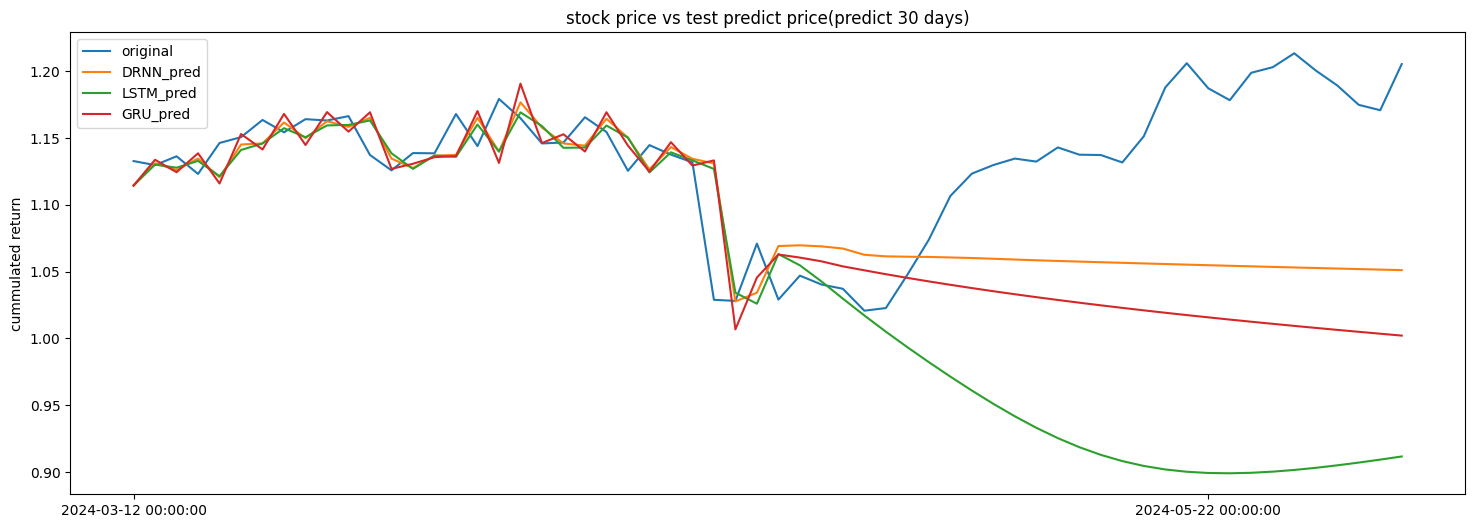

In [168]:
pred_DRNN = []
pred_LSTM = []
pred_GRU = []
predict_days = 30
X = X_test[-1][-predict_days-window_size:-predict_days]
for x in X:
    pred = model_DRNN(x).detach().float()
    pred_DRNN.append(pred)

    pred = model_LSTM(x).detach().float()
    pred_LSTM.append(pred)

    pred = model_GRU(x).detach().float()
    pred_GRU.append(pred)
X = X_test[-1][-predict_days]
DRNN_x , LSTM_x,GRU_x = X,X,X
for i in range(predict_days):
    pred = model_DRNN(DRNN_x).detach().float()
    pred_DRNN.append(pred)
    DRNN_x = torch.stack((*DRNN_x[1:],pred),dim=0)

    pred = model_LSTM(LSTM_x).detach().float()
    pred_LSTM.append(pred)
    LSTM_x = torch.stack((*LSTM_x[1:],pred),dim=0)

    pred = model_GRU(GRU_x).detach().float()
    pred_GRU.append(pred)
    GRU_x = torch.stack((*GRU_x[1:],pred),dim=0)

plt.figure(figsize=(18,6))

plt.plot(range(len(data_[-predict_days-window_size:])),data_[-predict_days-window_size:],label = 'original')
plt.plot(range(0,len(pred_DRNN)),pred_DRNN,label = 'DRNN_pred')
plt.plot(range(0,len(pred_LSTM)),pred_LSTM,label = 'LSTM_pred')
plt.plot(range(0,len(pred_GRU)),pred_GRU,label = 'GRU_pred')
lables = nflx.data.index
step = 50
ticks = range(days-predict_days-window_size,days,step)
plt.xticks(range(0,predict_days+window_size,step),lables[ticks])
plt.ylabel('cummulated return')
plt.title('stock price vs test predict price(predict 30 days)')
plt.legend()
plt.show()

[tensor([0.8977]), tensor([0.9109]), tensor([0.9022]), tensor([0.8969]), tensor([0.8997]), tensor([0.9271]), tensor([0.9197]), tensor([0.9295]), tensor([0.9265]), tensor([0.9285]), tensor([0.9314]), tensor([0.9293]), tensor([0.9220]), tensor([0.9224]), tensor([0.9031]), tensor([0.9136]), tensor([0.9134]), tensor([0.9089]), tensor([0.8960]), tensor([0.8989]), tensor([0.9018]), tensor([0.9236]), tensor([0.9080]), tensor([0.9090]), tensor([0.9206]), tensor([0.9253]), tensor([0.9180]), tensor([0.9410]), tensor([0.9487]), tensor([0.9590]), tensor([0.9764]), tensor([0.9879]), tensor([0.9888]), tensor([0.9786]), tensor([0.9889]), tensor([0.9897]), tensor([1.0044]), tensor([0.9935]), tensor([0.9835]), tensor([0.9935]), tensor([0.9961]), tensor([1.0025]), tensor([1.0164]), tensor([1.0069]), tensor([0.9826]), tensor([0.9864]), tensor([0.9841]), tensor([0.9504]), tensor([0.9468]), tensor([0.9539]), tensor([0.9559]), tensor([0.9606]), tensor([0.9614]), tensor([0.9516]), tensor([0.9580]), tensor([0

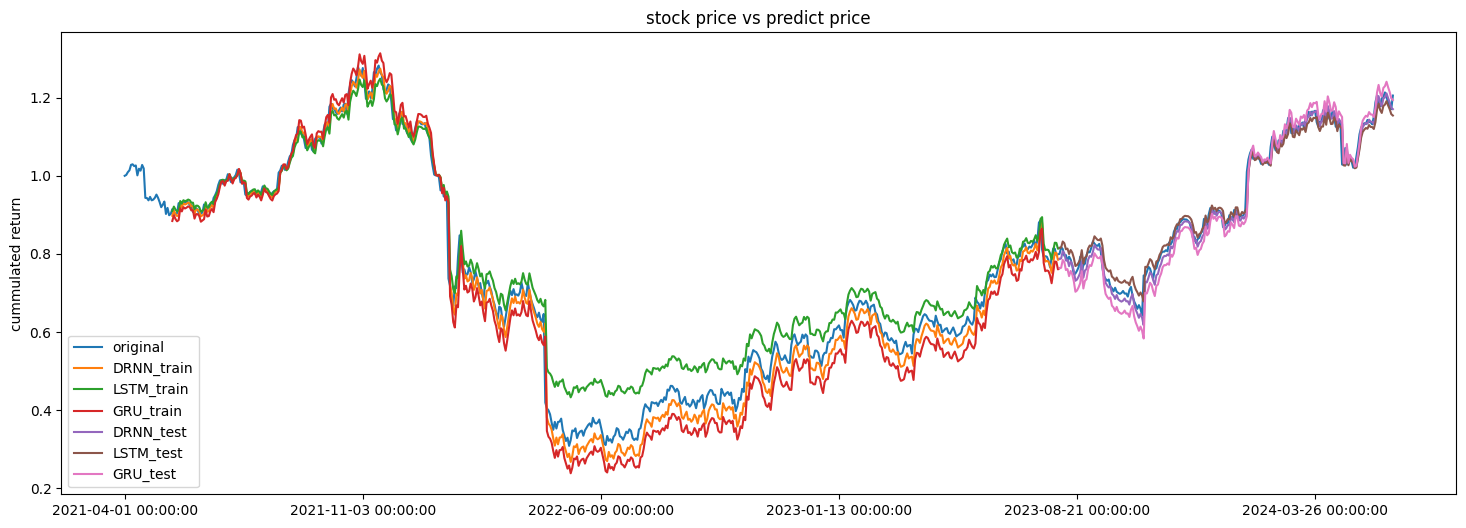

In [171]:
pred_DRNN = []
pred_LSTM = []
pred_GRU = []
dummy_size = 29 # < window_size
X = X_train
for batch  in X:
    for x in batch:
        dummy = torch.ones((dummy_size,1))
        x = torch.stack((*dummy,*x[dummy_size-window_size:]),dim=0)
        pred = model_DRNN(x).detach().float()
        pred_DRNN.append(pred)
        pred = model_LSTM(x).detach().float()
        pred_LSTM.append(pred)
        pred = model_GRU(x).detach().float()
        pred_GRU.append(pred)
X= X_test
for batch in X:
    for x in batch:
        dummy = torch.ones((dummy_size,1))
        x = torch.stack((*dummy,*x[dummy_size-window_size:]),dim=0)
        pred = model_DRNN(x).detach().float()
        pred_DRNN.append(pred)
        pred = model_LSTM(x).detach().float()
        pred_LSTM.append(pred)
        pred = model_GRU(x).detach().float()
        pred_GRU.append(pred)
print(pred_DRNN)
import matplotlib.pylab as plt
plt.figure(figsize=(18,6))
plt.plot(range(len(data_)),data_,label = 'original')
plt.plot(range(window_size,window_size+len(pred_DRNN[:train_days])),pred_DRNN[:train_days],label = 'DRNN_train')
plt.plot(range(window_size,window_size+len(pred_LSTM[:train_days])),pred_LSTM[:train_days],label = 'LSTM_train')
plt.plot(range(window_size,window_size+len(pred_GRU[:train_days])),pred_GRU[:train_days],label = 'GRU_train')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_DRNN[train_days-1:])),pred_DRNN[train_days-1:],label = 'DRNN_test')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_LSTM[train_days-1:])),pred_LSTM[train_days-1:],label = 'LSTM_test')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_GRU[train_days-1:])),pred_GRU[train_days-1:],label = 'GRU_test')
lables = nflx.data.index
step = 150
ticks = range(0,days,step)
plt.xticks(ticks,lables[ticks])
plt.ylabel('cummulated return')
plt.title('stock price vs predict price')
plt.legend()
plt.show()


[tensor([1.0769]), tensor([1.0884]), tensor([1.0804]), tensor([1.0760]), tensor([1.0786]), tensor([1.1025]), tensor([1.0954]), tensor([1.1042]), tensor([1.1013]), tensor([1.1031]), tensor([1.1056]), tensor([1.1037]), tensor([1.0974]), tensor([1.0979]), tensor([1.0810]), tensor([1.0906]), tensor([1.0902]), tensor([1.0863]), tensor([1.0751]), tensor([1.0779]), tensor([1.0804]), tensor([1.0995]), tensor([1.0852]), tensor([1.0865]), tensor([1.0966]), tensor([1.1005]), tensor([1.0940]), tensor([1.1142]), tensor([1.1203]), tensor([1.1291]), tensor([1.1439]), tensor([1.1534]), tensor([1.1540]), tensor([1.1453]), tensor([1.1542]), tensor([1.1548]), tensor([1.1673]), tensor([1.1578]), tensor([1.1494]), tensor([1.1581]), tensor([1.1602]), tensor([1.1656]), tensor([1.1773]), tensor([1.1690]), tensor([1.1484]), tensor([1.1521]), tensor([1.1500]), tensor([1.1210]), tensor([1.1185]), tensor([1.1247]), tensor([1.1264]), tensor([1.1304]), tensor([1.1310]), tensor([1.1225]), tensor([1.1282]), tensor([1

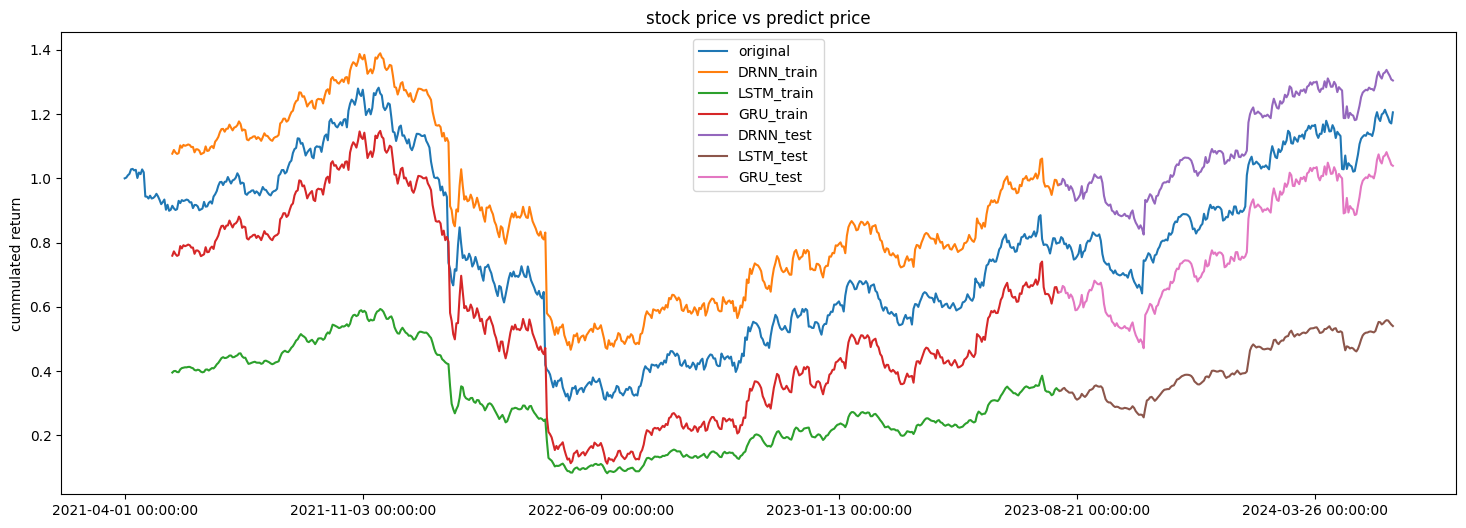

In [174]:
pred_DRNN = []
pred_LSTM = []
pred_GRU = []
dummy_size = 29 # < window_size
X = X_train
for batch  in X:
    for x in batch:
        dummy = torch.ones((dummy_size,1))
        x = x[-2:]
        pred = model_DRNN(x).detach().float()
        pred_DRNN.append(pred)
        pred = model_LSTM(x).detach().float()
        pred_LSTM.append(pred)
        pred = model_GRU(x).detach().float()
        pred_GRU.append(pred)
X= X_test
for batch in X:
    for x in batch:
        dummy = torch.ones((dummy_size,1))
        x = x[-2:]
        pred = model_DRNN(x).detach().float()
        pred_DRNN.append(pred)
        pred = model_LSTM(x).detach().float()
        pred_LSTM.append(pred)
        pred = model_GRU(x).detach().float()
        pred_GRU.append(pred)
print(pred_DRNN)
import matplotlib.pylab as plt
plt.figure(figsize=(18,6))
plt.plot(range(len(data_)),data_,label = 'original')
plt.plot(range(window_size,window_size+len(pred_DRNN[:train_days])),pred_DRNN[:train_days],label = 'DRNN_train')
plt.plot(range(window_size,window_size+len(pred_LSTM[:train_days])),pred_LSTM[:train_days],label = 'LSTM_train')
plt.plot(range(window_size,window_size+len(pred_GRU[:train_days])),pred_GRU[:train_days],label = 'GRU_train')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_DRNN[train_days-1:])),pred_DRNN[train_days-1:],label = 'DRNN_test')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_LSTM[train_days-1:])),pred_LSTM[train_days-1:],label = 'LSTM_test')
plt.plot(range(window_size+train_days-1,window_size+train_days-1+len(pred_GRU[train_days-1:])),pred_GRU[train_days-1:],label = 'GRU_test')
lables = nflx.data.index
step = 150
ticks = range(0,days,step)
plt.xticks(ticks,lables[ticks])
plt.ylabel('cummulated return')
plt.title('stock price vs predict price')
plt.legend()
plt.show()
